In [1]:
import os
import json
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
import re
import requests

In [2]:
def load_api_key(path: str = "../keys.json") -> None:
    """Load OpenAI API key from a JSON file into environment."""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    os.environ["OPENAI_API_KEY"] = data.get("openai_api_key")


def evaluate_two_mindmaps(ground_truth_path: str, prediction_path: str) -> dict:
    """Evaluate a single pair of ground-truth vs generated mind maps using GPT-4o-mini.

    Returns a dict of scores and comments for Visual, Cognitive, Functional, Structural, and overall."""
    # Read files
    with open(ground_truth_path, 'r', encoding='utf-8') as f:
        ground_truth = f.read().strip()
    with open(prediction_path, 'r', encoding='utf-8') as f:
        prediction = f.read().strip()

    prompt = f"""
You are an expert evaluator. Compare two mind maps based on the following dimensions:

1. **Cognitive Indicators**: How easily can a user understand and mentally process the information?  
   Consider clarity, flow of ideas, and thematic relevance.

2. **Structural Indicators**: How well-organized and logically complete is the mind map?  
   Consider grouping of ideas, coverage of key concepts, level of detail, and consistent hierarchy.

Scoring Instructions (Use a 1–7 Likert scale):
- Use **4** if the generated mind map is about equal in quality to the ground truth.
- Use **5–7** if the generated mind map is better than the ground truth (7 = much better).
- Use **3–1** if the generated mind map is worse than the ground truth (1 = much worse).

Return your evaluation in the following JSON format (no extra text):

{{
  "cognitive_score": int,
  "cognitive_comment": "string",
  "structural_score": int,
  "structural_comment": "string"
}}

Ground Truth Mind Map:
{ground_truth}

Generated Mind Map:
{prediction}
"""
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY not set — run load_api_key() first.")

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "gpt-4o",
        "messages": [
            {"role": "system", "content": "You are a strict evaluator of mind maps."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response.raise_for_status()

    text = response.json()["choices"][0]["message"]["content"].strip()
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        match = re.search(r"\{.*\}", text, re.S)
        if match:
            return json.loads(match.group())
        raise




In [3]:
load_api_key()

# Replace these with your two file paths
ground_truth_file = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0001.txt"
prediction_file = "../data/tqa_train_val_test/test/test_predictions_rlhf/prediction_L_0001.txt"

result = evaluate_two_mindmaps(ground_truth_file, prediction_file)
print(json.dumps(result, indent=2))

{
  "cognitive_score": 5,
  "cognitive_comment": "The generated mind map provides a broader context by including sections on Earth Science Investigations and Scientific Communication, which enhances understanding of the scientific process. It also clearly delineates the role of scientists and the importance of scientific inquiry, making it easier to grasp the broader implications of scientific work.",
  "structural_score": 6,
  "structural_comment": "The generated mind map is more comprehensive and better organized, with distinct sections for Scientific Inquiry, Earth Science Investigations, and Scientific Communication. It covers a wider range of topics and maintains a consistent hierarchy, making it more logically complete and detailed compared to the ground truth."
}


In [4]:
load_api_key()

# Replace these with your two file paths
ground_truth_file = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0001.txt"
prediction_file = "../data/gen_mindmap/mindmap_L0001.txt"

result = evaluate_two_mindmaps(ground_truth_file, prediction_file)
print(json.dumps(result, indent=2))

{
  "cognitive_score": 5,
  "cognitive_comment": "The generated mind map presents a more detailed and nuanced exploration of the scientific method and its components, making it easier for users to understand the flow of scientific inquiry. It also emphasizes the importance of scientific inquiry and lifelong learning, which adds thematic depth.",
  "structural_score": 6,
  "structural_comment": "The generated mind map is better organized with a clear hierarchy and logical grouping of ideas. It covers key concepts with more detail, such as the peer review process and the purpose of models, and maintains a consistent structure throughout, enhancing its logical completeness."
}


In [5]:


def evaluate_folder_and_save(ground_truth_folder: str, prediction_folder: str, output_file: str) -> None:
    """
    Evaluate all mind map pairs in the given folders and store the results in a JSON file.

    Ground truth files are expected to be named like:
      mermaid_code_L_0001.txt

    The corresponding prediction file should be named:
      prediction_L_0001.txt
    """
    evaluations = {}
    # Iterate over files in the ground truth folder.
    for filename in os.listdir(ground_truth_folder):
        # Check that the file follows the naming pattern.
        if not filename.startswith("mermaid_code_"):
            continue

        gt_path = os.path.join(ground_truth_folder, filename)
        # Replace the prefix to create the prediction file name.
        pred_filename = filename.replace("mermaid_code_", "prediction_")
        pred_path = os.path.join(prediction_folder, pred_filename)
        
        if os.path.isfile(gt_path) and os.path.isfile(pred_path):
            try:
                result = evaluate_two_mindmaps(gt_path, pred_path)
                evaluations[filename] = result
                print(f"Evaluated: {filename} and {pred_filename}")
            except Exception as e:
                print(f"Error evaluating {filename}: {e}")
        else:
            print(f"Skipping {filename}: corresponding prediction file {pred_filename} not found.")

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(evaluations, f, indent=2)
    print(f"Saved evaluations to {output_file}")



In [6]:
def analyze_results(evaluations_file: str, ground_truth_folder: str, prediction_folder: str) -> None:
    """
    Load evaluations from the JSON file, compute average and standard deviation of scores,
    plot histograms and line plots, and print the best and worst mind map predictions
    (with their comments and full texts) for each category.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import json
    import statistics

    with open(evaluations_file, 'r', encoding='utf-8') as f:
        evaluations = json.load(f)

    if not evaluations:
        print("No evaluations found in file.")
        return

    score_keys = ["cognitive_score", "structural_score"]

    # Collect scores
    scores = {key: [] for key in score_keys}
    for fname, result in evaluations.items():
        for key in score_keys:
            try:
                scores[key].append((fname, float(result.get(key, 0))))
            except Exception as e:
                print(f"Error processing score for {fname} in {key}: {e}")

    # Compute average and standard deviation
    score_stats = {}
    for key in score_keys:
        values = [score for _, score in scores[key]]
        if values:
            score_stats[key] = {
                "mean": sum(values) / len(values),
                "std": statistics.stdev(values) if len(values) > 1 else 0.0
            }
        else:
            score_stats[key] = {"mean": 0.0, "std": 0.0}

    print("Score Summary:")
    print(json.dumps(score_stats, indent=2))

    # Plotting
    for key in score_keys:
        values = sorted(scores[key], key=lambda x: x[1])
        score_values = [score for _, score in values]

        # Line plot
        plt.figure(figsize=(12, 4))
        plt.plot(score_values, marker='o')
        plt.title(f"Line Plot of {key}")
        plt.xlabel("Sample (sorted by score)")
        plt.ylabel("Score")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Histogram
        plt.figure(figsize=(8, 4))
        sns.histplot(score_values, bins=[0.5 + i for i in range(8)], discrete=True)
        plt.xticks(range(1, 8))
        plt.title(f"Distribution of {key} scores")
        plt.xlabel("Score (Likert scale)")
        plt.ylabel("Frequency")
        plt.grid(axis="y")
        plt.tight_layout()
        plt.show()

    # Print best/worst samples
    for key in score_keys:
        if not scores[key]:
            continue
        worst = min(scores[key], key=lambda x: x[1])
        best = max(scores[key], key=lambda x: x[1])
        comment_key = key.replace("_score", "_comment")

        for label, fname in [("Worst", worst[0]), ("Best", best[0])]:
            score = dict(scores[key])[fname]
            comment = evaluations[fname].get(comment_key, '')
            print(f"\nCategory: {key} - {label}: {fname} with score {score}")
            print(f"Comment: {comment}")

            gt_file = os.path.join(ground_truth_folder, fname)
            pred_file = os.path.join(prediction_folder, fname.replace("mermaid_code_", "prediction_"))

            try:
                with open(gt_file, 'r', encoding='utf-8') as f:
                    gt_content = f.read().strip()
                with open(pred_file, 'r', encoding='utf-8') as f:
                    pred_content = f.read().strip()

                print("Ground Truth:")
                print(gt_content)
                print("\nPrediction:")
                print(pred_content)
            except Exception as e:
                print(f"Error loading files for {fname}: {e}")


In [7]:

load_api_key()

# Set your folder paths (adjust as needed)
ground_truth_folder = "../data/tqa_train_val_test/test/mindmap_text_v1"
prediction_folder = "../data/tqa_train_val_test/test/test_predictions_rlhf"
output_file = "../data/tqa_train_val_test/test/llm_judge_evaluation_results_rlhf_4o.json"



In [8]:
# Step 1: Evaluate all mind map pairs and save the individual JSON outputs.
evaluate_folder_and_save(ground_truth_folder, prediction_folder, output_file)


Evaluated: mermaid_code_L_0379.txt and prediction_L_0379.txt
Evaluated: mermaid_code_L_0988.txt and prediction_L_0988.txt
Evaluated: mermaid_code_L_0922.txt and prediction_L_0922.txt
Evaluated: mermaid_code_L_0696.txt and prediction_L_0696.txt
Evaluated: mermaid_code_L_1075.txt and prediction_L_1075.txt
Evaluated: mermaid_code_L_0254.txt and prediction_L_0254.txt
Evaluated: mermaid_code_L_0711.txt and prediction_L_0711.txt
Evaluated: mermaid_code_L_0559.txt and prediction_L_0559.txt
Evaluated: mermaid_code_L_0588.txt and prediction_L_0588.txt
Evaluated: mermaid_code_L_0377.txt and prediction_L_0377.txt
Evaluated: mermaid_code_L_0632.txt and prediction_L_0632.txt
Evaluated: mermaid_code_L_0195.txt and prediction_L_0195.txt
Evaluated: mermaid_code_L_0029.txt and prediction_L_0029.txt
Evaluated: mermaid_code_L_0448.txt and prediction_L_0448.txt
Evaluated: mermaid_code_L_0600.txt and prediction_L_0600.txt
Evaluated: mermaid_code_L_0339.txt and prediction_L_0339.txt
Evaluated: mermaid_code_

Score Summary:
{
  "cognitive_score": {
    "mean": 3.9951923076923075,
    "std": 1.078993967621119
  },
  "structural_score": {
    "mean": 3.7451923076923075,
    "std": 1.3432515030776078
  }
}


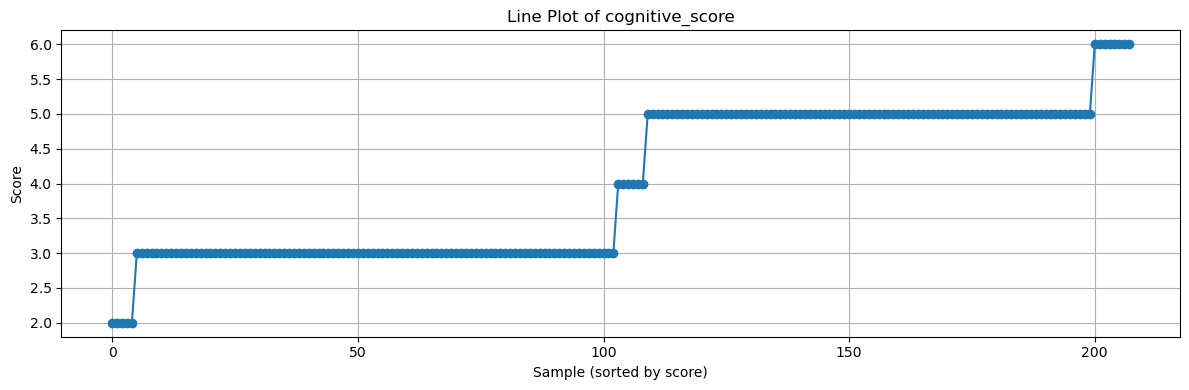

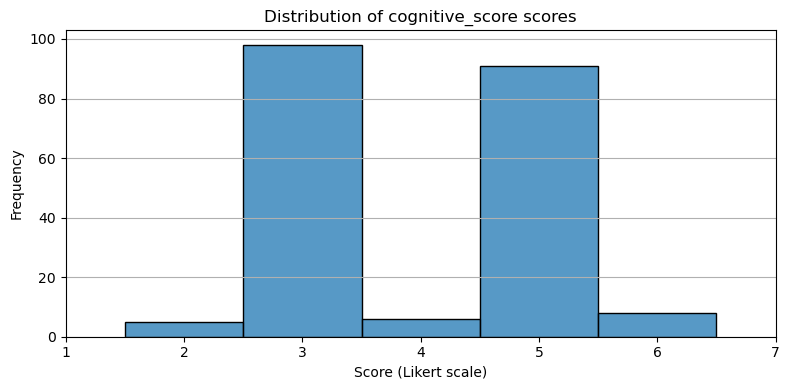

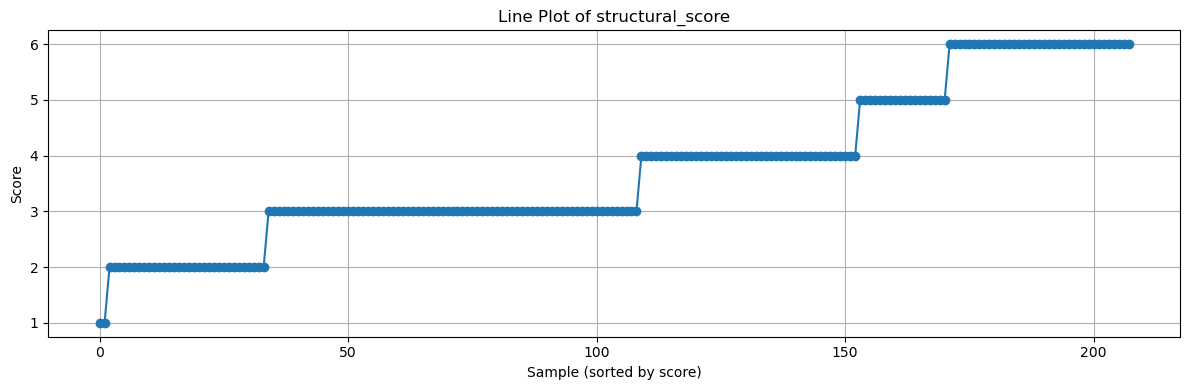

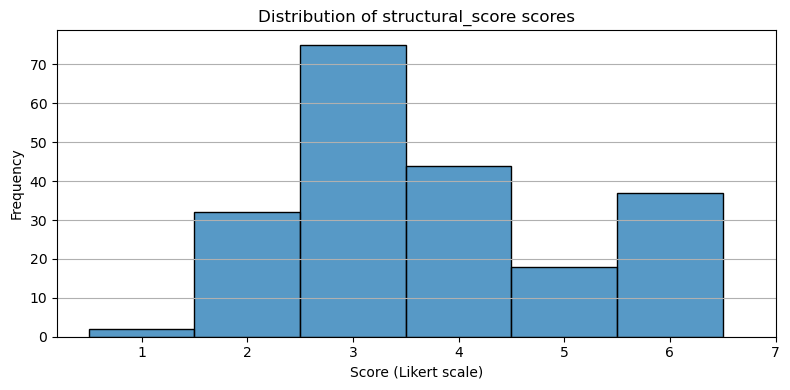


Category: cognitive_score - Worst: mermaid_code_L_0486.txt with score 2.0
Comment: The generated mind map is incomplete and lacks clarity. It only briefly mentions the composition of a balanced meal and tools for healthy eating without providing any details or thematic relevance. The ground truth mind map provides a comprehensive and clear breakdown of each topic, making it easier to understand and process.
Ground Truth:
mindmap
  Choosing Healthy Foods
    Balanced Meal
      Plate Composition
        Largest Section
        Food Groups
    Tools for Healthy Eating
      MyPyramid
        Food Groups
          Grains
          Vegetables
          Fruits
          Oils
          Dairy
          Meat and Beans
        Nutrient Recommendations
      MyPlate
        Visual Guidelines
        Portion Control
        Foods to Increase
        Foods to Reduce
      Nutrition Labels
        Serving Size
        Calories
        Percent Daily Values
          Low Nutrients
          High Nut

In [9]:
import matplotlib.pyplot as plt
# Step 2: Later, load the saved JSON file, compute average metrics, and plot histograms.
analyze_results(output_file,ground_truth_folder, prediction_folder)